In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplication/TASObsTrends/*.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)

In [11]:
from keras.models import Sequential
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
import matplotlib.pyplot as plt
import tensorflow as tf

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []

predictions_all = []
validations_all = []
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=4e-5, restore_best_weights=True)
for x in range(20):
    predictions = []
    validations = []
    for model_idx in range(len(ModelNames)):
        
        # Reshape target and predictor data for model
        TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
        TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
        TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
        TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

        # Train model
        #TrainingTargetDataReshaped = np.transpose([TrainingTargetDataReshaped[:,0], TrainingTargetDataReshaped[:,3]])
        TrainingTargetDataReshaped = np.transpose(TrainingTargetDataReshaped[:,0])
        
        # reshape predictor data
        TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
        TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
        TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
        TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))
        TrainingTargetDataReshaped = np.transpose(TrainingTargetDataReshaped[:,0])
        TrainingPredictorDataReshaped = np.reshape(TrainingPredictorData[model_idx], (len(TrainingPredictorData[model_idx]),72,144))
        TestingPredictorDataReshaped = np.reshape(TestingPredictorData[model_idx], (len(TestingPredictorData[model_idx]),72,144))
        

        
        # model design
        model = models.Sequential()
        model.add(layers.Conv2D(filters=72, kernel_size=3, activation='relu', 
                                input_shape=(72, 144, 1)))
        model.add(layers.MaxPooling2D(3))
        model.add(layers.Flatten())
        #model.add(layers.Dense(8, activation='relu'))
        #model.add(layers.Dropout(0.3))
        #model.add(layers.Conv2D(72, 3, activation='relu', input_shape=(72, 144, 1)))
        #model.add(layers.MaxPooling2D(3))
        #model.add(layers.Dropout(0.5))
        #model.add(layers.Flatten())
        model.add(layers.Dense(1))
        model.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=.00001))
        history = model.fit(TrainingPredictorDataReshaped, TrainingTargetDataReshaped, epochs=2, 
                verbose=1)#, validation_split=0.1, callbacks=[callback], shuffle=True, batch_size=32)
        
        # Predict using trained model
        Y_pred = model.predict(TestingPredictorDataReshaped)
        
        # Apply trained model to observations
        #Y_pred_Gistemp = model.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
        #Y_pred_ERA5 = model.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
        #Y_pred_HadCrut = model.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
        
        # Save output for plotting
        NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
        #gistemp_predictions.append(Y_pred_Gistemp)
        #era5_predictions.append(Y_pred_ERA5)
        #hadcrut_predictions.append(Y_pred_HadCrut)
        #validations.append([TestingTargetDataReshaped[:,0], TestingTargetDataReshaped[:,3]])
        validations.append([TestingTargetDataReshaped[:,0]])
        predictions.append(Y_pred)
        #print(ModelNames[model_idx])
        true_vals = [TestingTargetDataReshaped[:,0]]
        #nat_val = true_vals[0]
        for_val = true_vals[0]
        #print(stats.pearsonr(for_val, Y_pred.T[0])[0])
        #print(np.nanmean(np.abs((np.array(nat_val) - np.array(Y_pred.T[0])))))
        #print(np.nanmean(np.abs((np.array(for_val) - np.array(Y_pred.T[0])))))
    predictions_all.append(predictions)
    validations_all.append(validations)

    
"""vals_nat = list(np.concatenate(np.array(validations)[:,0]).flat)
vals_for = list(np.concatenate(np.array(validations)[:,1]).flat)
preds_nat = np.concatenate(predictions, axis=0)[:,0]
preds_for = np.concatenate(predictions, axis=0)[:,1]
allsimulationNat_r = stats.pearsonr(vals_nat, preds_nat)[0]
sqrt_mse_nat = np.sqrt(np.nanmean((np.array(vals_nat) - np.array(preds_nat))**2))
allsimulationFor_r = stats.pearsonr(vals_for, preds_for)[0]
sqrt_mse_for = np.sqrt(np.nanmean((np.array(vals_for) - np.array(preds_for))**2))"""

Epoch 1/2
267/267 [==============================] - 29s 107ms/step - loss: 4.3808e-04
Epoch 2/2
2/2 [==============================] - 0s 6ms/step
Epoch 1/2
259/259 [==============================] - 29s 110ms/step - loss: 4.3751e-04
Epoch 2/2
2/2 [==============================] - 0s 11ms/step
Epoch 1/2
276/276 [==============================] - 30s 108ms/step - loss: 4.6789e-04
Epoch 2/2
1/1 [==============================] - 0s 125ms/step
Epoch 1/2
267/267 [==============================] - 31s 113ms/step - loss: 3.9444e-04
Epoch 2/2
2/2 [==============================] - 0s 7ms/step
Epoch 1/2
290/290 [==============================] - 33s 113ms/step - loss: 4.6999e-04
Epoch 2/2
1/1 [==============================] - 0s 134ms/step
Epoch 1/2
273/273 [==============================] - 31s 115ms/step - loss: 4.4014e-04
Epoch 2/2
1/1 [==============================] - 0s 112ms/step
Epoch 1/2
275/275 [==============================] - 31s 110ms/step - loss: 4.7432e-04
Epoch 2/2
1/1 [===

In [10]:
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

0.6349774621723785
0.022889283


In [3]:
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

0.6346639700320055
0.022876916


In [11]:
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

0.7235287222087352
0.019290913


In [15]:
#natural
gistemp_predictions = np.array(gistemp_predictions)
era5_predictions = np.array(era5_predictions)
hadcrut_predictions = np.array(hadcrut_predictions)
print(np.nanmean(gistemp_predictions[:,0,0]), np.nanmean(era5_predictions[:,0,0]), np.nanmean(hadcrut_predictions[:,0,0]))

-0.06305799791535764 -0.04877930281123271 -0.04812077320605501


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

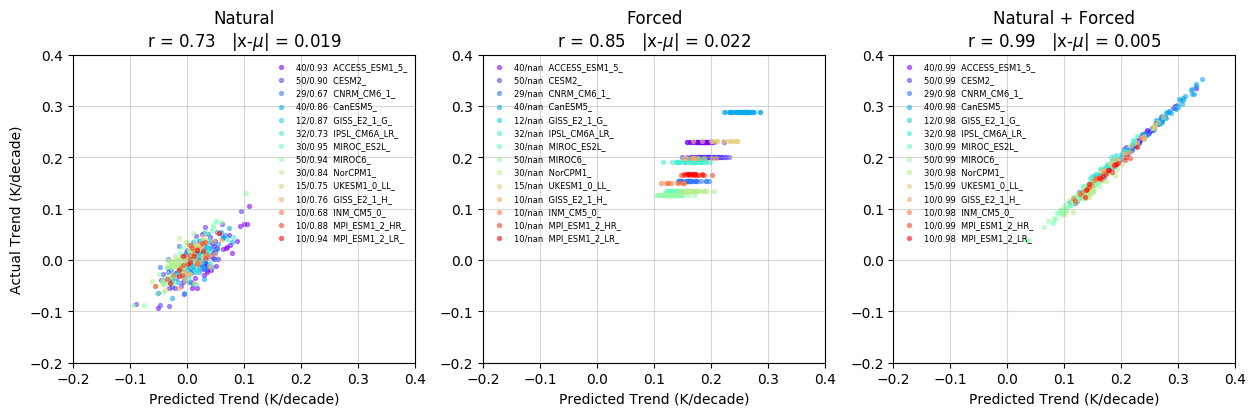

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.abs((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:5])

In [8]:
#fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
all_r_values = []
all_vals = []
all_preds = []
for cv_idx in range(0, len(Validation_data)):
    NameValidatationPredictions_ = Validation_data[cv_idx]
    architecture = model_architecture[cv_idx]
    for model_idx in range(len(NameValidatationPredictions_)):
        modelName = NameValidatationPredictions_[model_idx][0]
        #ValidationData = TestingTotalTrend[model_idx]
        
        ValidationData_ = NameValidatationPredictions_[model_idx][1][:,0]
        PredictedData = NameValidatationPredictions_[model_idx][2]
        N_ensembles = len(PredictedData)
        
        r_values = []
        for predictant_idx in range(1):
            #val = ValidationData[:,predictant_idx]
            val = ValidationData_
            all_vals.append(val)
            pred = PredictedData
            all_preds.append(pred)
            r = stats.pearsonr(val, pred)[0]
            r_values.append(r)
            
            #label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
            #axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
            #axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

            #axs_obj.set_ylim(-0.5,1)
            #axs_obj.set_xlim(-0.5,.5)
            #axs_obj.set_ylabel('Natural Trend (K/decade)')
            #axs_obj.set_xlabel('Predicted Natural Trend (K/decade)')
        all_r_values.append(r_values)
    vals = list(np.concatenate(all_vals).flat)
    preds = list(np.concatenate(all_preds).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    print(architecture, allsimulation_r)
    #axs_obj.set_title('PLS Regression: r = ' + str(allsimulation_r)[:4])


[10, 10, 10] 0.7924572995685586
[10, 10, 30] 0.7071214555018503
[10, 10, 50] 0.7355653297365119
[10, 30, 10] 0.7344139828650673
[10, 30, 30] 0.7401018674279727
[10, 30, 50] 0.7467617778578687
[10, 50, 10] 0.7505504147538407
[10, 50, 30] 0.7560301456691383
[10, 50, 50] 0.7602680744927679
[30, 10, 10] 0.7624503843801518
[30, 10, 30] 0.7640222430430352
[30, 10, 50] 0.7619433086120699
[30, 30, 10] 0.7585356880685704
[30, 30, 30] 0.7504506215524567
[30, 30, 50] 0.7489253971051661
[30, 50, 10] 0.7422642192308384
[30, 50, 30] 0.7442156183977024
[30, 50, 50] 0.7429826353985097
[50, 10, 10] 0.7279814300964123
[50, 10, 30] 0.7241047807730641
[50, 10, 50] 0.7268971322974741
[50, 30, 10] 0.7183981380836217
[50, 30, 30] 0.713803515634895
[50, 30, 50] 0.7166736948174663
[50, 50, 10] 0.716310982648042
[50, 50, 30] 0.7190447645659723
[50, 50, 50] 0.719117926819916


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

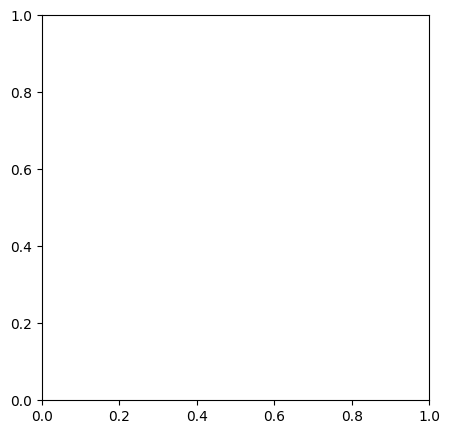

In [4]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = TestingTotalTrend[model_idx]
    #ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,0]
        val = ValidationData
        pred = PredictedData[:,0] + PredictedData[:,3]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-1,2)
        axs_obj.set_xlim(-1,2)
        axs_obj.set_ylabel('Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural + Predicted Forced Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


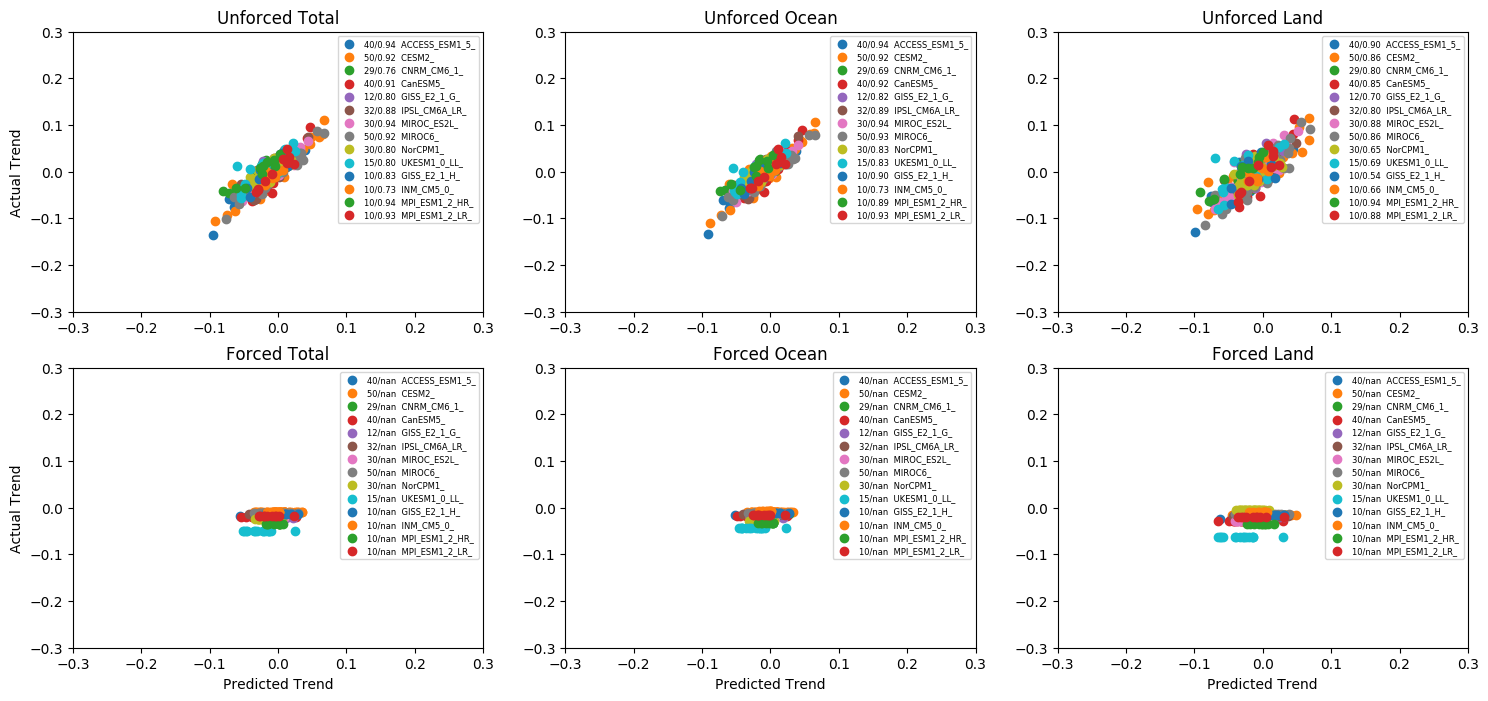

In [8]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

# the second axis in ValidationData and PredictedData is stored as follows
titles = ['Unforced Total', 'Unforced Ocean', 'Unforced Land', 'Forced Total', 'Forced Ocean', 'Forced Land']

all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)

    r_values = []
    for predictant_idx in range(6):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        axs_obj = axs.flatten()[predictant_idx]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id)
        axs_obj.legend(loc=1, prop={'size': 6})
        axs_obj.set_ylim(-.3,.3)
        axs_obj.set_xlim(-.3,.3)
        axs_obj.set_title(titles[predictant_idx])
        if (predictant_idx == 0) or (predictant_idx == 3):
            axs_obj.set_ylabel('Actual Trend')
        if (predictant_idx >=3):
            axs_obj.set_xlabel('Predicted Trend')
    all_r_values.append(r_values)


In [7]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,0])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,3])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,0] + np.nanmean(ERA5_predictions, axis=0)[0,3])

NameError: name 'ERA5_predictions' is not defined

In [6]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []
